<a href="https://colab.research.google.com/github/pingb2/Portfolio-optimization-using-mean-variance-model/blob/main/2_Mean_variance_%2B_DE_%5B01_01_2018_31_12_2018%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Import Libraries and stocks data**

In [ ]:
#Import the python libraries
from pandas_datareader import data as web
import pandas as pd
import numpy as np
import math

from numpy import random
from datetime import datetime
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
BIG_SCORE = 1.e7     # Set Big score
randint = np.random.randint
randfloat = np.random.uniform
randperm = np.random.permutation

In [ ]:
def top_n_stock(df,n):
    returns = df.pct_change(len(df)-1)
    variance = df.pct_change()
    variance = variance.var()
    df_summary = pd.DataFrame(returns.tail(1).T)
    df_summary['column2'] = variance 
    df_summary.columns = ['Return', 'Variance']
    
    return df_summary.sort_values(['Return'], ascending=False).head(n)

In [ ]:
def Print_dict(assets_list, weights_list):     # Print assets and weights function
    np.set_printoptions(precision=2)
    zip_iterator = zip(assets_list, weights_list)
    a_dictionary = dict(zip_iterator)
    print(a_dictionary)

In [ ]:
def cal_Return(startDate, endDate, best_weights):     # calculate return from percent change of return
    df = pd.DataFrame()

    for stock in assets:
      df[stock] = web.DataReader(stock, data_source='yahoo', start = stockStartDate, end = stockEndDate)['Adj Close']

    N_trading = len(df)     # Number of tradeing day of stock
    B_returns = df.pct_change()
    B_cov = B_returns.cov() * N_trading
    B_var = np.dot(best_weights.T, np.dot(B_cov, best_weights))
    B_Return = np.sum(B_returns.mean() * best_weights) * N_trading
    print("Return : %.2f" %(B_Return*100) + "%")

In [ ]:
# List of stock in portfolio
assets = ['ADVANC.BK', 'AOT.BK', 'BBL.BK', 'BJC.BK', 'BTS.BK',
          'CENTEL.BK','CPALL.BK', 'CPF.BK', 'CPN.BK', 'DELTA.BK',
          'DTAC.BK', 'EA.BK','GLOBAL.BK', 'HMPRO.BK', 'INTUCH.BK',
          'KBANK.BK', 'KTB.BK','KTC.BK', 'MINT.BK', 'PTT.BK',
          'PTTEP.BK', 'PTTGC.BK','RATCH.BK', 'SCB.BK', 'SCC.BK',
          'TISCO.BK', 'TOA.BK', 'TOP.BK', 'TRUE.BK', 'TU.BK']

In [ ]:
# Set Start date and End date 
stockStartDate = '2018-01-01'
stockEndDate = '2018-12-31'

In [ ]:
# Create dataframe
df = pd.DataFrame()

for stock in assets:
    df[stock] = web.DataReader(stock, data_source='yahoo', start = stockStartDate, end = stockEndDate)['Adj Close']

N_trading = len(df)     # Number of tradeing day of stock
Rf_TH = 0.017           # Risk Free rate (TH)

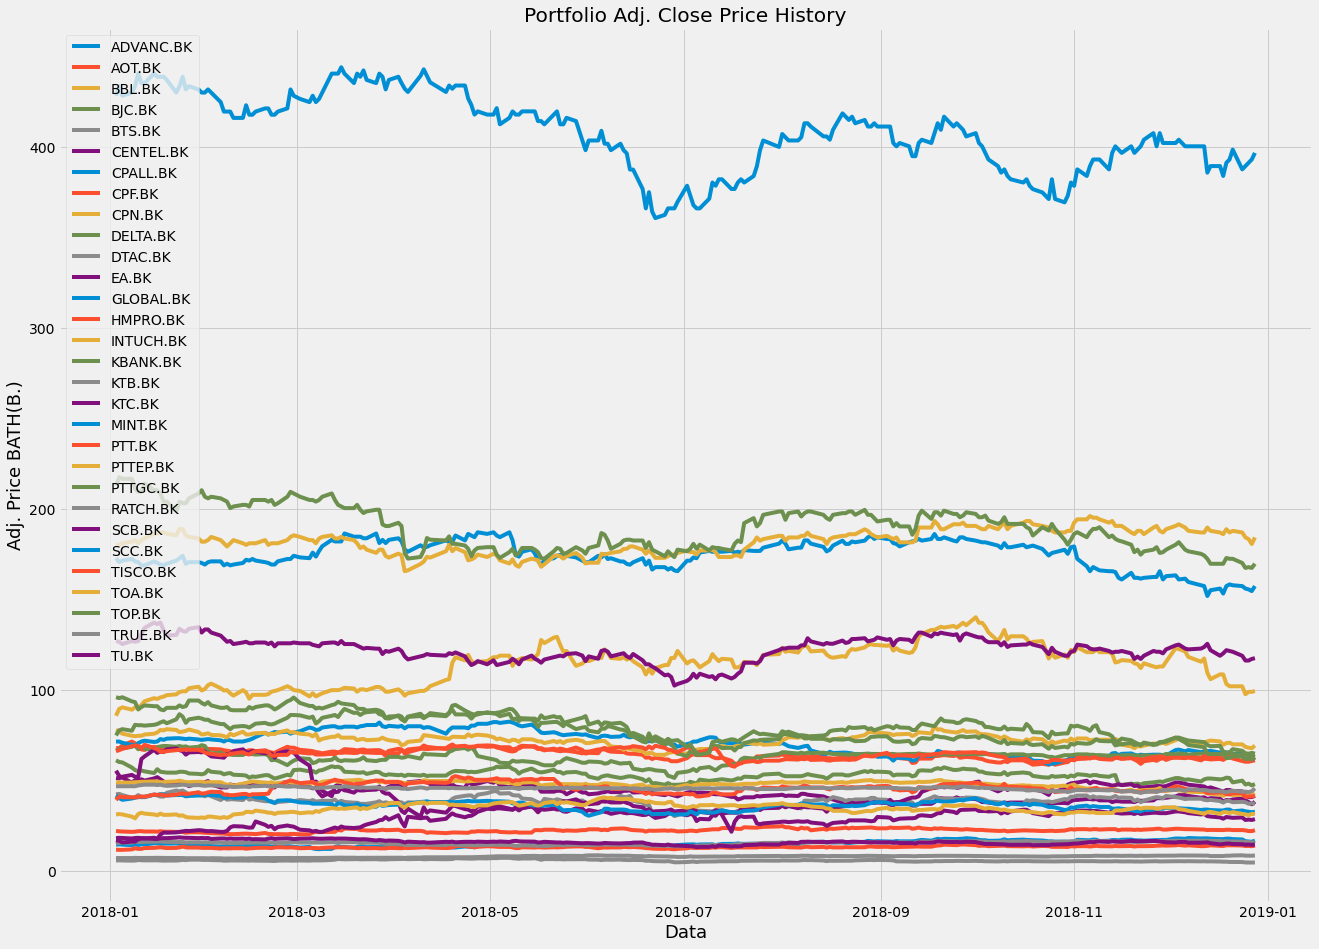

In [ ]:
# Portfolio Adj. Closr Price
title = 'Portfolio Adj. Close Price History'
my_stocks = df

plt.figure(figsize=(20, 15))
for c in my_stocks.columns.values:
    plt.plot(my_stocks[c], label = c)


plt.title(title)
plt.xlabel('Data', fontsize = 18)
plt.ylabel('Adj. Price BATH(B.)', fontsize = 18)
plt.legend(my_stocks.columns.values, loc= 'upper left')
plt.show()

In [ ]:
top_n_stock(df,5)     # Print top 5 of stock sort by return

,Return,Variance
KTC.BK,0.680100,0.001944
BTS.BK,0.197091,0.000092
HMPRO.BK,0.187318,0.000254
PTTEP.BK,0.159144,0.000443
GLOBAL.BK,0.155417,0.000384


#**Define DE and Other function**

In [ ]:
class DE:

    def __init__(self, Np, D, iter, E_return):
        self.X = random.uniform(size=(Np,D))     # Random vector X 
        self.U = np.empty([Np,D])                # Create vector U
        self.V = np.empty([Np,D])                # Create vector V
        
        self.iter = iter                         # Iteration
        self.Np = Np                             # Number of population
        self.D = D                               # Dimension of problem(number of stock)
        self.F = 0.5                             # Mutation rate
        self.Cr = 0.1                            # Crossover rate
        self.weights_X = [None] * Np             # Weight of vector X (for calculate score in selection step)
        self.weights_U = [None] * Np             # Weight of vector U (for calculate score in selection step)
        self.score_X = [None] * Np               # Score of weight X
        self.score_U = [None] * Np               # Score of weight U
        self.E_return = E_return                 # Expected return

        self.index_best_weights = None           # Index of best weights (for mutation strategy)
        self.best_weights = None                 # Best weights of asset
        self.best_score = BIG_SCORE              # Best score

        for i in range(Np):
            self.weights_X[i] = (self.X[i]/self.X[i].sum()) * 1     # Divide weights of asset to (0,1) | sum of weights = 1

    def get_weights_X(self):     # Get weights of vector X function
        return self.weights_X
  
    def get_weights_U(self):     # Get weights of vector U function
        return self.weights_U

    def get_best_weights(self):      # Get best weight function
        return self.best_weights

    def fitness_function(self, Rp, Variance):     # Sharpe ratio (fitness function)Obj = MAX(Sharpe ratio)
        min_diff_return = BIG_SCORE
        min_diff_var = BIG_SCORE
        min_var = None
        for i in range(self.Np):
          local_score = Variance[i]
          if local_score <= self.best_score and Rp[i] >= self.E_return:       # IF MIN(variance) is TRUE  and Return >= Expected return is TRUE  set best weight
              self.best_score = local_score
              self.best_weights = self.weights_X[i]
              min_var = local_score
          elif local_score <= self.best_score and Rp[i] < self.E_return:      # IF MIN(variance) is TRUE  and Return >= Expected return is FALSE find min different of return to set best weight
              if ((self.E_return - Rp[i]) < min_diff_return):
                  min_diff_return = self.E_return - Rp[i]
                  self.best_score = local_score
                  self.best_weights = self.weights_X[i]
                  min_var = local_score
          elif local_score > self.best_score and Rp[i] >= self.E_return:      # IF MIN(variance) is FALSE and Return >= Expected return is TRUE  find min different of variance to set best weight
              if min_var is None: min_var = min(Variance)
              if ((Variance[i] - min_var) < min_diff_var):
                  min_diff_var = Variance[i] - min_var
                  self.best_score = local_score
                  self.best_weights = self.weights_X[i]
          else:                                                               # Both condition are FALSE find min different of return and variance to set best weight
              if min_var is None: min_var = min(Variance)
              if ((Variance[i] - min_var) < min_diff_var) and ((self.E_return - Rp[i]) < min_diff_return):
                  min_diff_var = Variance[i] - min_var
                  min_diff_return = self.E_return - Rp[i]
                  self.best_score = local_score
                  self.best_weights = self.weights_X[i]

  
    def mutation(self, Np, F, D):     # Mutation function strategy : DE/best/2/bin
        for i in range(Np):
            R = randperm(Np)
            j = R[0]
            k = R[1]
            l = R[2]
            m = R[3]

            if (j==i):
                j=R[4]
            elif (k==i):
                k=R[4]
            elif (l==i):
                l=R[4]
            elif (m==i):
                m=R[4]

            self.V[i] = self.X[self.index_best_weights] + self.F * (self.X[j] + self.X[k] - self.X[l] - self.X[m])

            for j in range(D):     # Set vector in bound[0,1]
                if (self.V[i][j] > 1.00):
                    self.V[i][j] = 1.00 
                if (self.V[i][j] < 0.00):
                    self.V[i][j] = 0.00

    def crossover(self, Np, Cr, D):     # Crossover function 
        for i in range (Np):
            jrand = math.floor(randfloat()*D)      # Jrandom
            for j in range (D):
                if (randfloat() <= Cr or j == jrand): 
                    self.U[i][j] = self.V[i][j]     # Crossover occurs
                else:
                    self.U[i][j] = self.X[i][j]     # Crossover doesn't occur
                self.weights_U[i] = (self.U[i] / self.U[i].sum()) * 1     # Divide weights of asset to (0,1) | sum of weights = 1
  
    def cal_score_X(self, Rp, Variance):     # Calculate score of weight X function
        min_diff_return = BIG_SCORE
        min_diff_var = BIG_SCORE
        for i in range(self.Np):
          local_score = Variance[i]
          if local_score <= self.best_score and Rp[i] >= self.E_return:       # IF MIN(variance) is TRUE  and Return >= Expected return is TRUE  set score = 0
              self.score_X[i] = 0
          elif local_score <= self.best_score and Rp[i] < self.E_return:      # IF MIN(variance) is TRUE  and Return >= Expected return is FALSE set score = different of return and expected return
                  self.score_X[i] = self.E_return - Rp[i]
          elif local_score > self.best_score and Rp[i] >= self.E_return:      # IF MIN(variance) is FALSE and Return >= Expected return is TRUE  set score = different of variance and min variance
                  self.score_X[i] = Variance[i] - min(Variance)
          else:                                                               # Both condition are FALSE set score = different of return and expected return + different of variance and min variance
                  self.score_X[i] = (self.E_return - Rp[i]) + Variance[i] - min(Variance)
        self.index_best_weights = self.score_X.index(min(self.score_X))
        
    def cal_score_U(self, Rp, Variance):     # Calculate score of weight U function
        min_diff_return = BIG_SCORE
        min_diff_var = BIG_SCORE
        for i in range(self.Np):
          local_score = Variance[i]
          if local_score <= self.best_score and Rp[i] >= self.E_return:       # IF MIN(variance) is TRUE  and Return >= Expected return is TRUE  set score = 0
              self.score_U[i] = 0
          elif local_score <= self.best_score and Rp[i] < self.E_return:      # IF MIN(variance) is TRUE  and Return >= Expected return is FALSE set score = different of return and expected return
              self.score_U[i] = self.E_return - Rp[i]
          elif local_score > self.best_score and Rp[i] >= self.E_return:      # IF MIN(variance) is FALSE and Return >= Expected return is TRUE  set score = different of variance and min variance
              self.score_U[i] = Variance[i] - min(Variance)
          else:                                                               # Both condition are FALSE set score = different of return and expected return + different of variance and min variance
              self.score_U[i] = (self.E_return - Rp[i]) + Variance[i] - min(Variance)

    def selection(self, Np):     # Selection function
        for i in range (Np):
            if (self.score_X[i] > self.score_U[i]):
                self.X[i] = self.U[i]     # Updating Vector X
        for i in range(Np):
            self.weights_X[i] = (self.X[i]/self.X[i].sum()) * 1     # Divide weights of asset to (0,1) | sum of weights = 1 

In [ ]:
def Portfolio_proportion(StockData, Opt):
    iter = Opt.iter                           # Iteration
    port_AnnualReturn_x = [None] * Opt.Np     # Portfolio Annual Return X
    port_Variance_x = [None] * Opt.Np         # Portfolio Variance X
    port_AnnualReturn_u = [None] * Opt.Np     # Portfolio Annual Return U
    port_Variance_u = [None] * Opt.Np         # Portfolio Variance U
    var_arr = [None] * Opt.iter               # Variance array
    ret_arr = [None] * Opt.iter               # Return array
    for t in range(iter):
        weights = Opt.get_weights_X()           # Get weights
        for i in range(Opt.Np):
            returns = StockData.pct_change()                                               # Calculate returns = % change of stockdata
            cov_matrix = returns.cov() * N_trading                                         # Calculate covariance = covariance of returns * number of trading day
            port_Variance_x[i] = np.dot(weights[i].T, np.dot(cov_matrix, weights[i]))           # Calculate portfolio variance =  weight * covariance of returns X
            port_volatility = np.sqrt(port_Variance_x[i])                                  # Calculate volatility = square root(portfolio variance) X
            port_AnnualReturn_x[i] = np.sum(returns.mean() * weights[i]) * N_trading       # Calculate port Annual Return = mean(return) * weights * number of trading day X
        Opt.cal_score_X(port_AnnualReturn_x, port_Variance_x)                   # Calculate score X
        Opt.mutation(Opt.Np, Opt.F, Opt.D)                                               # Mutation step
        Opt.crossover(Opt.Np, Opt.Cr, Opt.D)                                             # Crossover step
        weights_U = Opt.get_weights_U()                                                  # Get weight U
        for i in range(Opt.Np):
            returns = StockData.pct_change()                                               
            cov_matrix = returns.cov() * N_trading                                         
            port_Variance_u[i] = np.dot(weights_U[i].T, np.dot(cov_matrix, weights_U[i]))       # Calculate portfolio variance =  weight * covariance of returns U
            port_volatility = np.sqrt(port_Variance_u[i])                                  # Calculate volatility = square root(portfolio variance) U
            port_AnnualReturn_u[i] = np.sum(returns.mean() * weights_U[i]) * N_trading     # Calculate port Annual Return = mean(return) * weights * number of trading day U
        Opt.cal_score_U(port_AnnualReturn_u, port_Variance_u)                   # Calculate score U
        for i in range(Opt.Np):
            returns = StockData.pct_change()                                               
            cov_matrix = returns.cov() * N_trading                                         
            port_Variance_x[i] = np.dot(weights[i].T, np.dot(cov_matrix, weights[i]))        
            port_volatility = np.sqrt(port_Variance_x)                                  
            port_AnnualReturn_x[i] = np.sum(returns.mean() * weights[i]) * N_trading                   
        Opt.selection(Opt.Np)                                                            # Selection step
        Opt.fitness_function(port_AnnualReturn_x,port_Variance_x)                
        best_weights = Opt.get_best_weights()                                            # Get best weights 
        print("Iteration :", t+1)                                                        # Print Sharpe ratio in every iteration
        B_returns = StockData.pct_change()
        B_cov = B_returns.cov() * N_trading
        B_var = np.dot(best_weights.T, np.dot(B_cov, best_weights))
        var_arr[t] = B_var                                                               # Collect variance value in all iteration in array
        print("Variance : %.6f" %var_arr[t])
        B_vol = np.sqrt(B_var)                       
        B_Return = np.sum(B_returns.mean() * best_weights) * N_trading
        ret_arr[t] = B_Return                                                            # Collect return value in all iteration in array
        print("Return : %.6f" %ret_arr[t])

    plt.subplots(1,2,figsize=(16,5))
    plt.subplot(1,2,1)
    plt.plot(var_arr, color='red')     # plot variance
    plt.title('Variance')
    plt.xlabel('Iteration')
    plt.ylabel('Variance')
    plt.subplot(1,2,2)
    plt.plot(ret_arr)     # plot return
    plt.title('Return')
    plt.xlabel('Iteration')
    plt.ylabel('Return')
    return Opt.get_best_weights()

# **Main**

In [ ]:
Np = 30                   # Number of population
D = len(assets)           # Dimension of problem(number of stock)
Iteration = 150           # Iteration
N_stock = len(assets)     # Number of stock
E_return = 0.20           # Expected return

Iteration : 1
Variance : 0.020511
Return : 0.030433
Iteration : 2
Variance : 0.019486
Return : 0.030717
Iteration : 3
Variance : 0.019737
Return : 0.033410
Iteration : 4
Variance : 0.019497
Return : 0.035923
Iteration : 5
Variance : 0.019497
Return : 0.035923
Iteration : 6
Variance : 0.020650
Return : 0.047401
Iteration : 7
Variance : 0.018282
Return : 0.047951
Iteration : 8
Variance : 0.018282
Return : 0.047951
Iteration : 9
Variance : 0.017970
Return : 0.083686
Iteration : 10
Variance : 0.017970
Return : 0.083686
Iteration : 11
Variance : 0.017970
Return : 0.083686
Iteration : 12
Variance : 0.022331
Return : 0.095531
Iteration : 13
Variance : 0.022125
Return : 0.097645
Iteration : 14
Variance : 0.018014
Return : 0.085257
Iteration : 15
Variance : 0.020571
Return : 0.090562
Iteration : 16
Variance : 0.022316
Return : 0.098234
Iteration : 17
Variance : 0.018711
Return : 0.118795
Iteration : 18
Variance : 0.018635
Return : 0.119831
Iteration : 19
Variance : 0.018635
Return : 0.119831
It

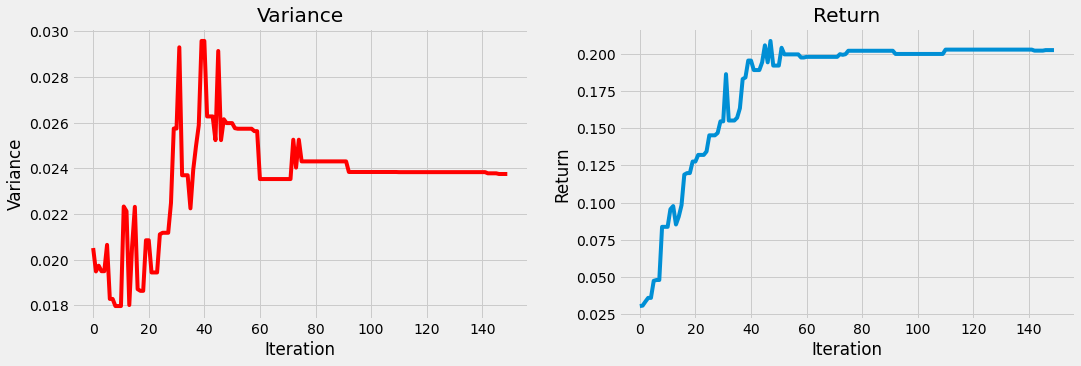

In [ ]:
Best_proportion = Portfolio_proportion(df, DE(Np, D, Iteration, E_return))     # Best proportion of this portfolio asset

In [ ]:
best_weights = Best_proportion
Print_dict(assets, Best_proportion)

{'ADVANC.BK': 0.0, 'AOT.BK': 0.0, 'BBL.BK': 0.048976220699383004, 'BJC.BK': 0.0, 'BTS.BK': 0.12952377422103906, 'CENTEL.BK': 0.0005066494256355779, 'CPALL.BK': 0.0063373285211612475, 'CPF.BK': 0.1004596316238458, 'CPN.BK': 0.0, 'DELTA.BK': 0.07966086531791955, 'DTAC.BK': 0.0, 'EA.BK': 0.0, 'GLOBAL.BK': 0.11964119994471406, 'HMPRO.BK': 0.12952377422103906, 'INTUCH.BK': 0.0, 'KBANK.BK': 0.0, 'KTB.BK': 0.08941311949442646, 'KTC.BK': 0.12625038594610807, 'MINT.BK': 0.0014186890534069916, 'PTT.BK': 0.0, 'PTTEP.BK': 0.11600054660364809, 'PTTGC.BK': 0.0, 'RATCH.BK': 0.0, 'SCB.BK': 0.00014462829136765057, 'SCC.BK': 0.0015839463167277024, 'TISCO.BK': 0.0, 'TOA.BK': 0.041004709817785985, 'TOP.BK': 0.0, 'TRUE.BK': 0.00955453050179173, 'TU.BK': 0.0}


In [ ]:
df_proportion = pd.DataFrame(best_weights, index=assets, columns=['Weight'])
df_proportion['Weight'] = df_proportion['Weight'].map('{:,.4f}'.format)
df_proportion

,Weight
ADVANC.BK,0.0000
AOT.BK,0.0000
BBL.BK,0.0490
BJC.BK,0.0000
BTS.BK,0.1295
CENTEL.BK,0.0005
CPALL.BK,0.0063
CPF.BK,0.1005
CPN.BK,0.0000
DELTA.BK,0.0797


In [ ]:
df_proportion.sort_values(['Weight'], ascending=False)

,Weight
BTS.BK,0.1295
HMPRO.BK,0.1295
KTC.BK,0.1263
GLOBAL.BK,0.1196
PTTEP.BK,0.1160
CPF.BK,0.1005
KTB.BK,0.0894
DELTA.BK,0.0797
BBL.BK,0.0490
TOA.BK,0.0410


In [ ]:
B_returns = df.pct_change()
B_cov = B_returns.cov() * N_trading
B_var = np.dot(best_weights.T, np.dot(B_cov, best_weights))
B_vol = np.sqrt(B_var)
B_Return = np.sum(B_returns.mean() * best_weights) * N_trading
print("Variance : %.4f" %B_var)
print("Return : %.2f" %(B_Return*100) + "%")

Variance : 0.0238
Return : 20.25%


In [ ]:
stockStartDate = '2019-01-01'
stockEndDate = '2019-06-30'

In [ ]:
cal_Return(stockStartDate, stockEndDate, best_weights)

Return : 16.47%
